In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, shapiro
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from IPython.display import display, HTML
import textwrap

# Apply CSS to make the output scrollable horizontally
display(HTML("<style>.output_scroll {overflow-x: auto; max-width: 100%;}</style>"))

data = pd.read_excel("C:/Users/libor/OneDrive/Plocha/Škola-LOQ/semestralkySP2.xlsx", sheet_name='248222')
continuous_vars = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']

def apply_log_to_columns(df, columns):
    return df.assign(**{col: np.log(df[col].where(df[col] > 0)) for col in columns if col in df.columns})

log_data = apply_log_to_columns(data, ['price', 'carat'])

print(data.head(200))
print(f"Number of rows: {len(data)}")
print(log_data.head(200))
print(f"Number of rows: {len(data)}")

     price  carat      cut color clarity  depth  table     x     y     z
0     8501   1.15  Premium     G    VVS2   58.4   59.0  6.92  6.84  4.02
1     1698   0.55  Premium     D     SI1   61.6   56.0  5.28  5.24  3.24
2     5969   1.24  Premium     D     SI2   59.1   59.0  7.03  6.98  4.14
3    11643   1.79    Ideal     H     SI2   61.5   56.0  7.77  7.81  4.79
4     6849   1.21  Premium     H     VS2   59.3   60.0  6.93  6.99  4.13
..     ...    ...      ...   ...     ...    ...    ...   ...   ...   ...
195   5045   1.95  Premium     H      I1   60.3   59.0  8.10  8.05  4.87
196    638   0.41     Good     E     SI2   63.3   56.0  4.69  4.73  2.98
197    655   0.30    Ideal     G    VVS2   62.2   57.0  4.25  4.30  2.66
198  11045   1.61    Ideal     H     VS2   61.4   57.0  7.52  7.57  4.63
199  16004   2.25  Premium     J     SI1   61.8   61.0  8.46  8.39  5.21

[200 rows x 10 columns]
Number of rows: 200
        price     carat      cut color clarity  depth  table     x     y     z


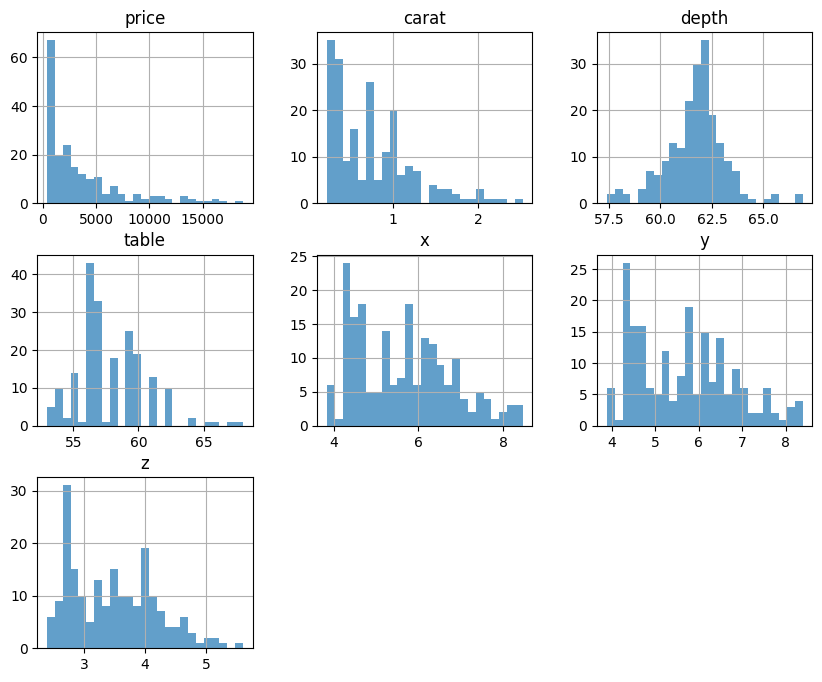

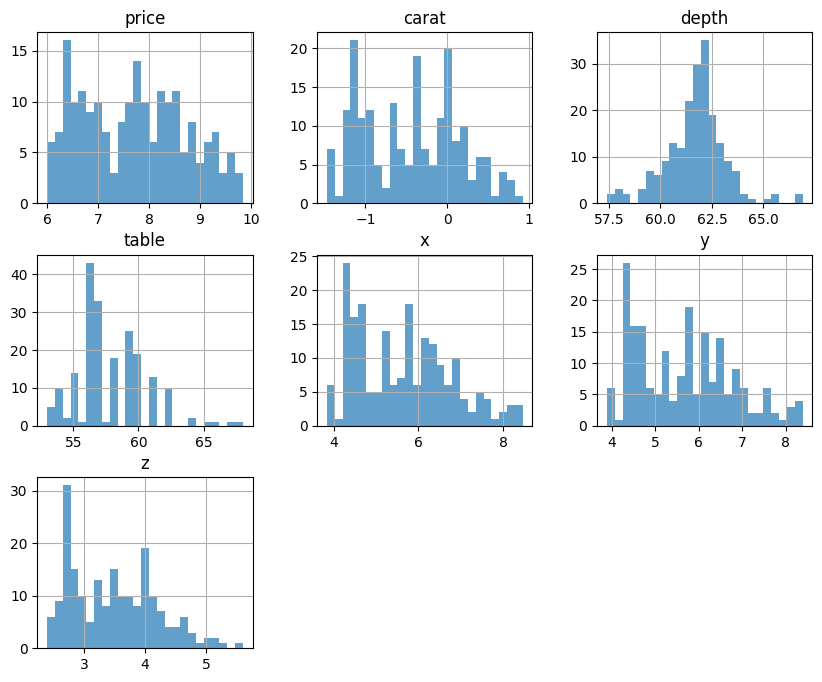

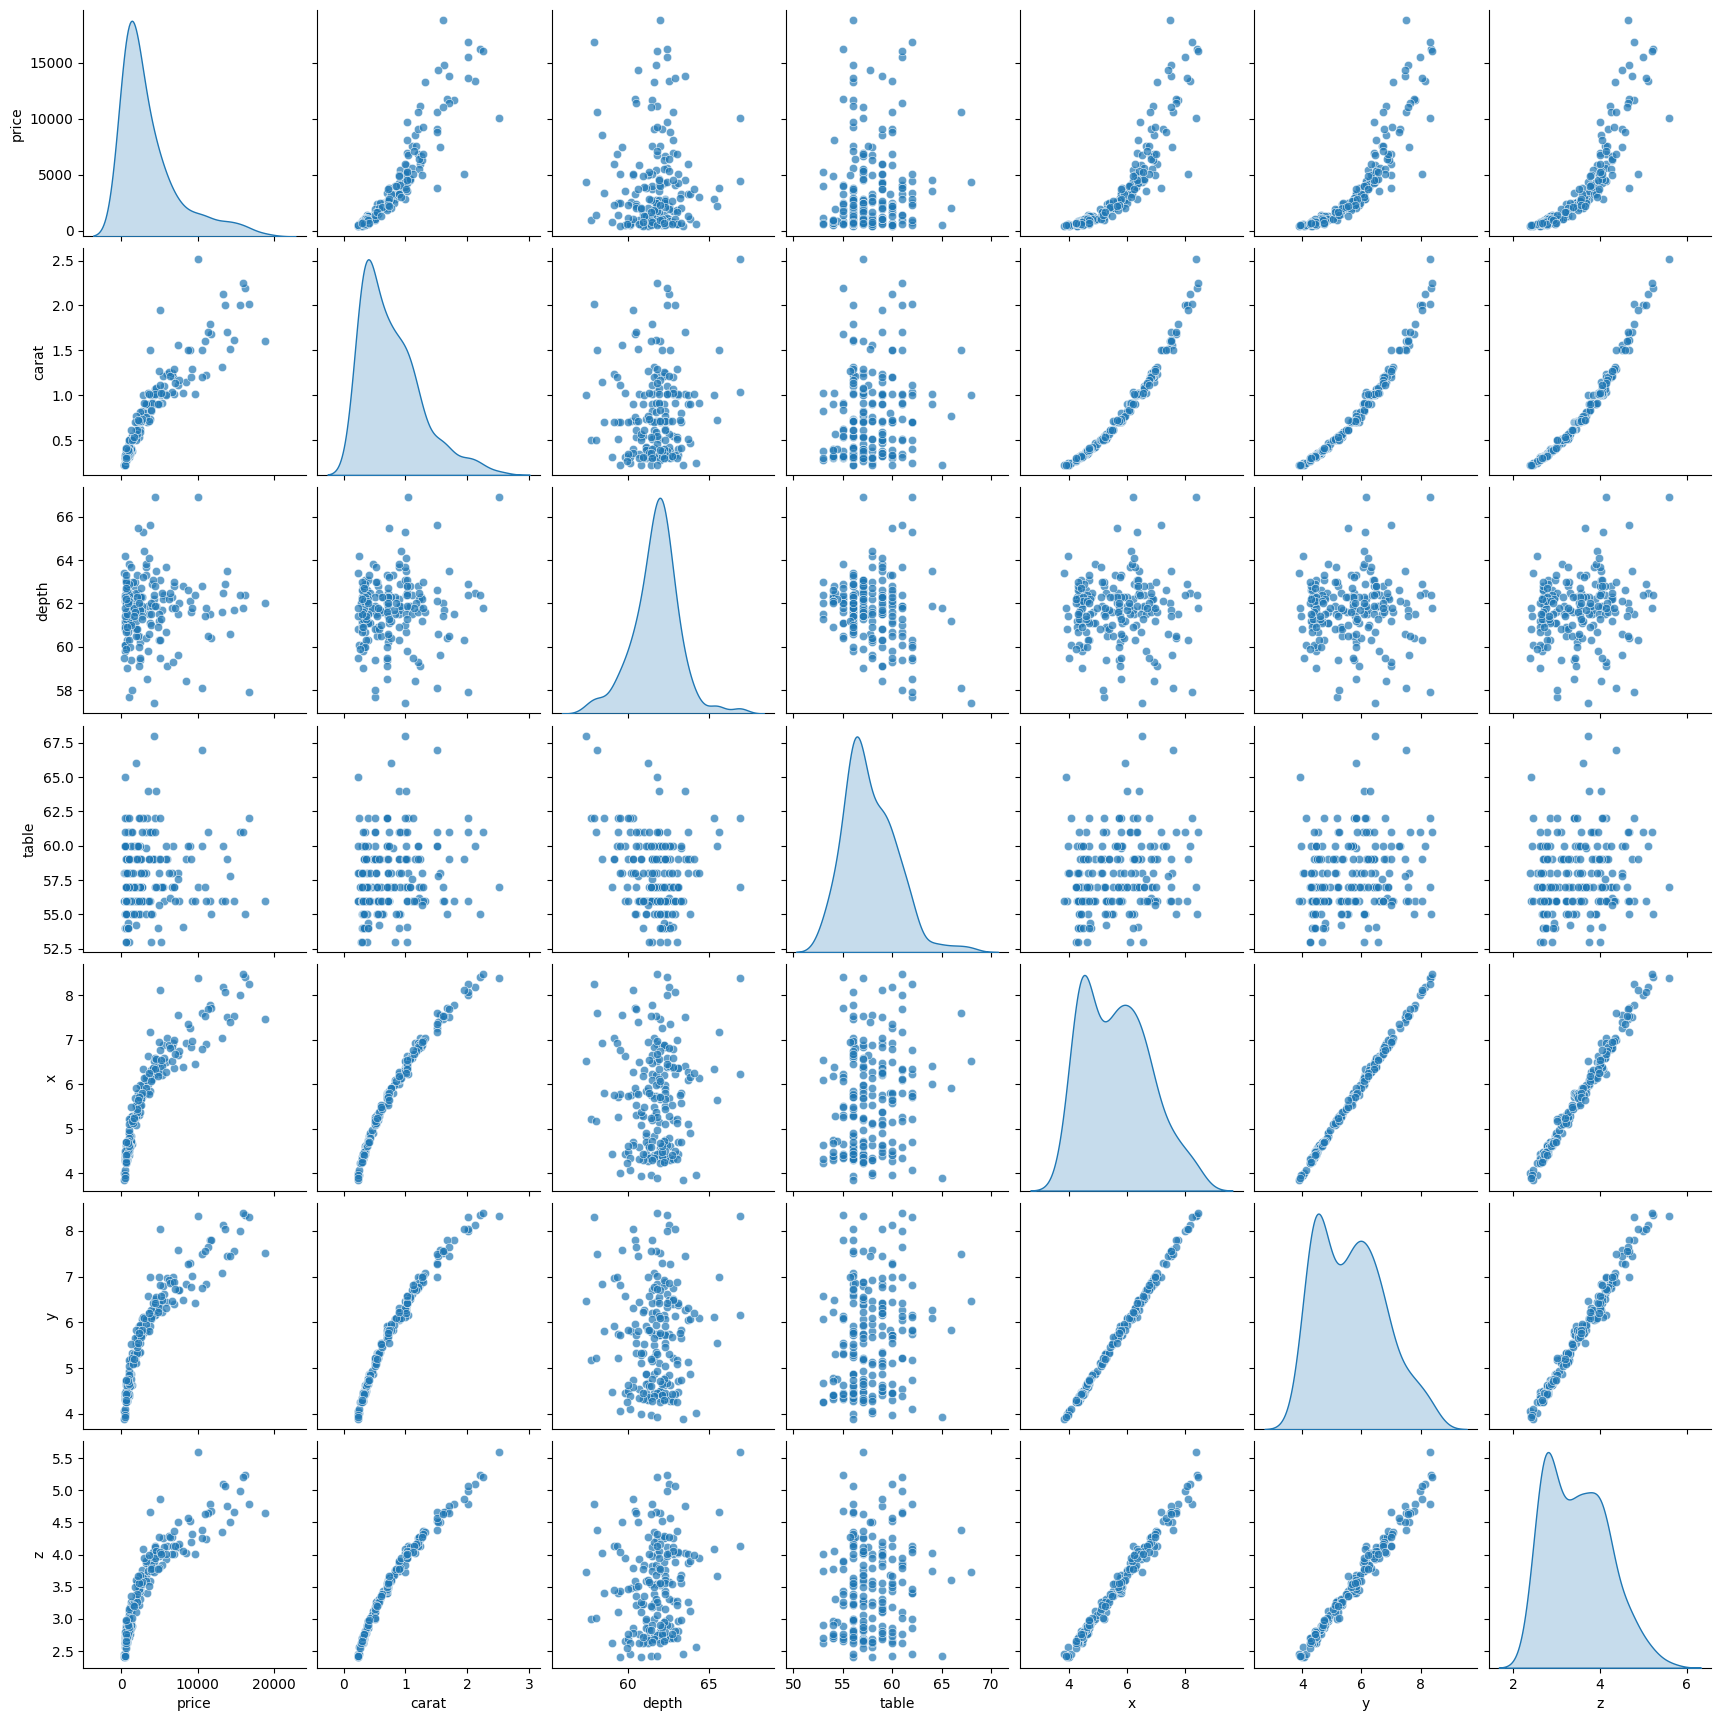

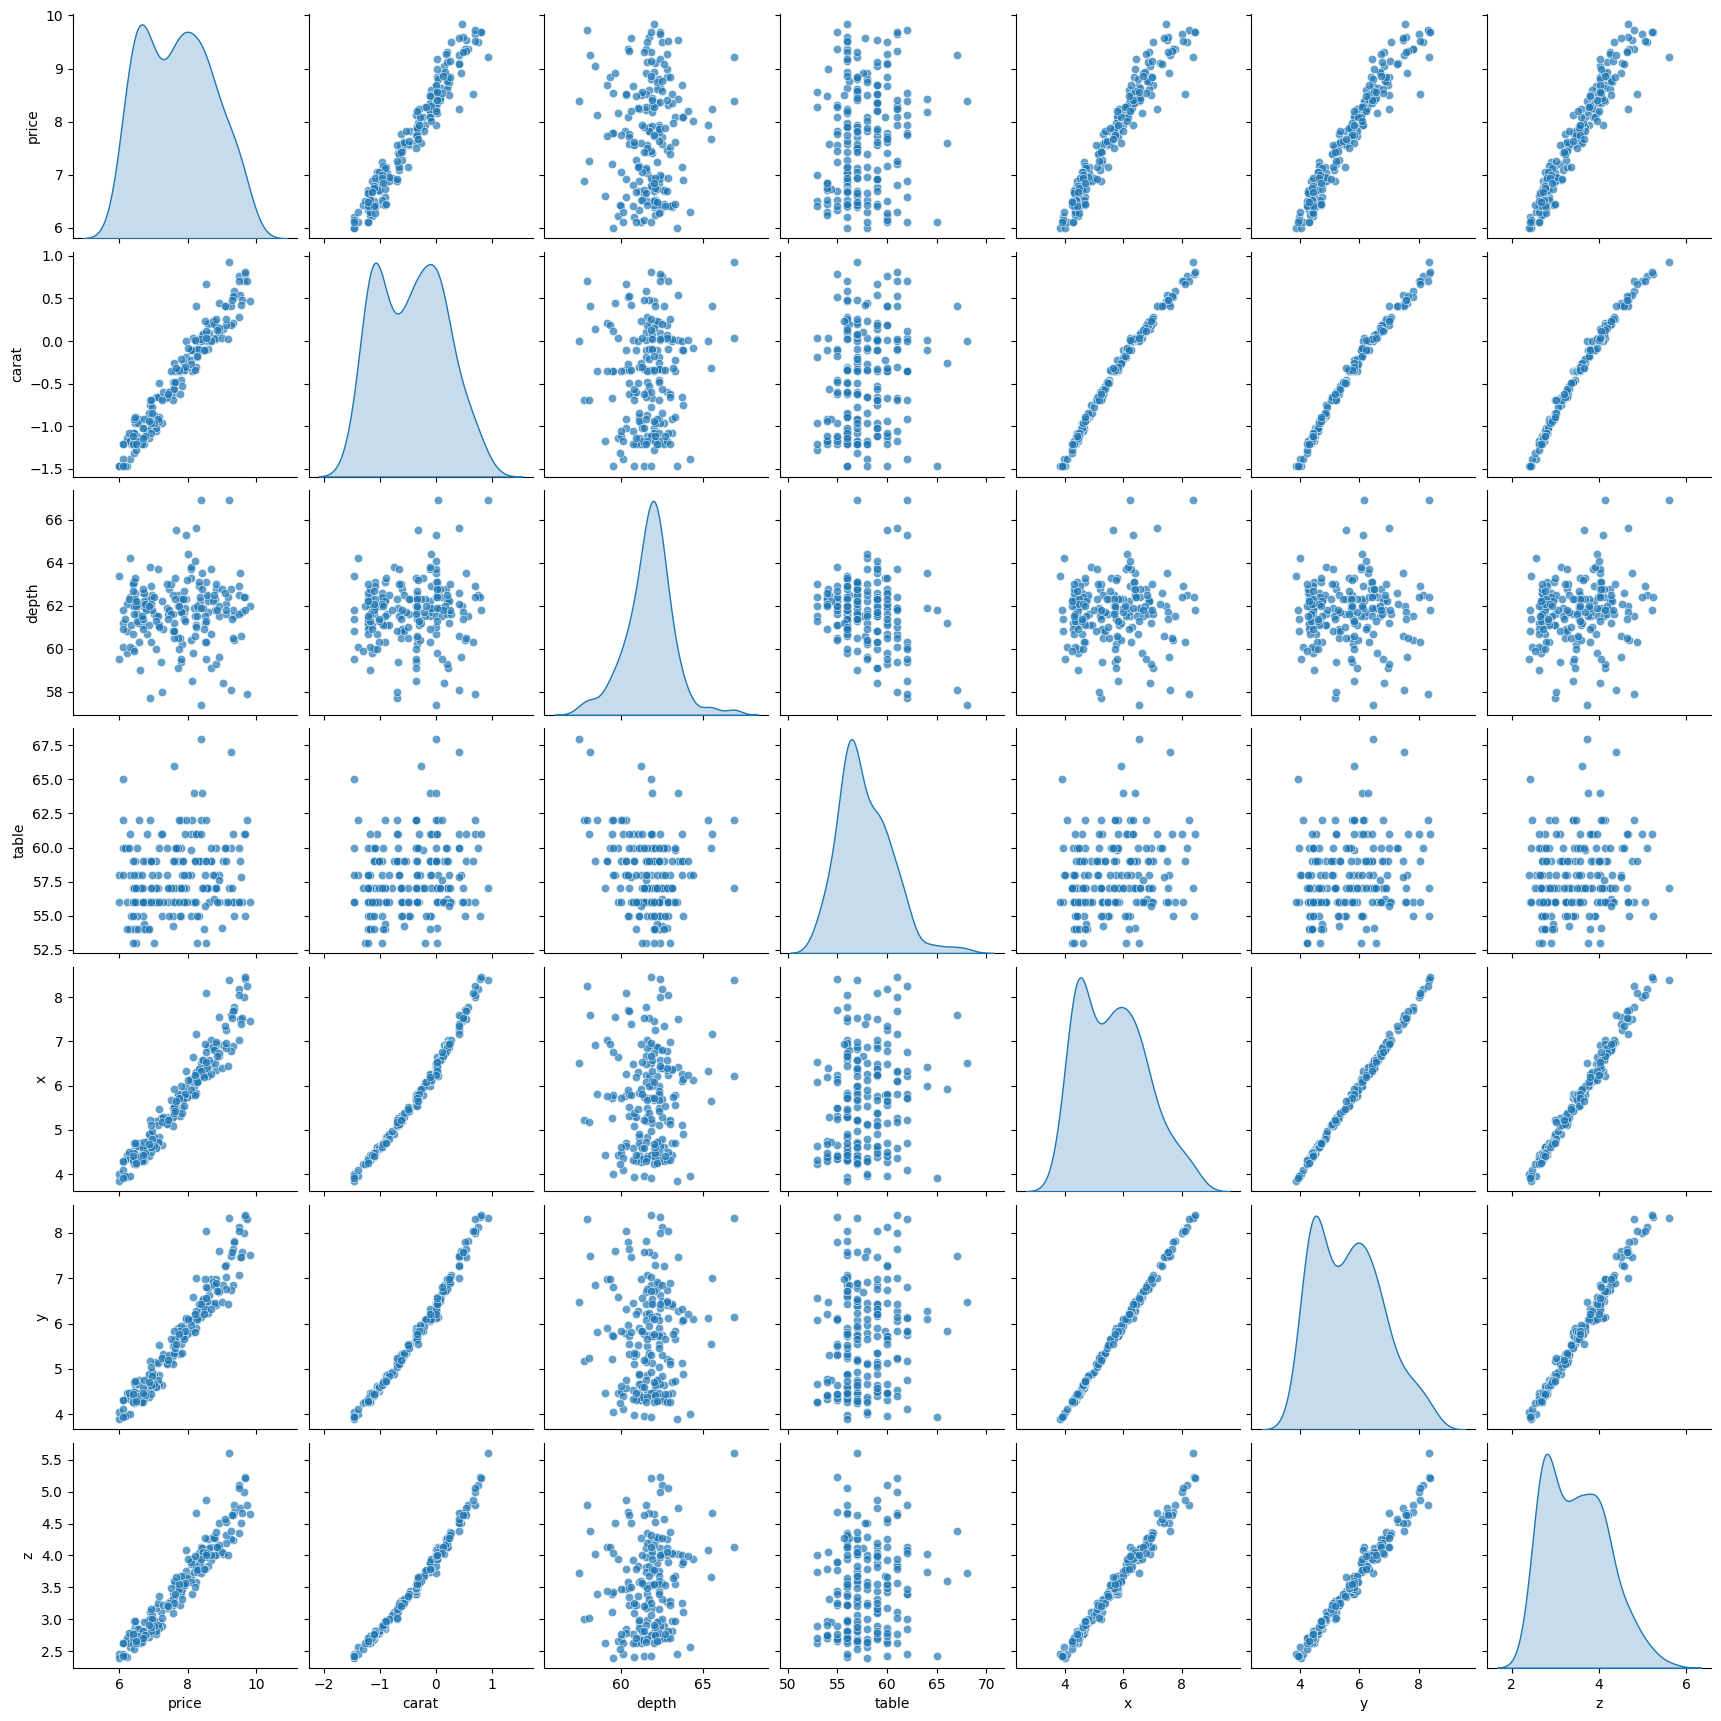

In [3]:
#uloha 1a)
data.hist(bins=25, figsize=(10, 8), alpha=0.7) # chage bins if need to widen or shrik intervals for data
log_data.hist(bins=25, figsize=(10, 8), alpha=0.7)
#sns.pairplot(data[continuous_vars], corner=True, diag_kind='kde', plot_kws={'alpha': 0.7}) # forgets duplicates
sns.pairplot(data[continuous_vars], diag_kind='kde', plot_kws={'alpha': 0.7}) # plot with original data
sns.pairplot(log_data[continuous_vars], diag_kind='kde', plot_kws={'alpha': 0.7}) # plot with transformed data

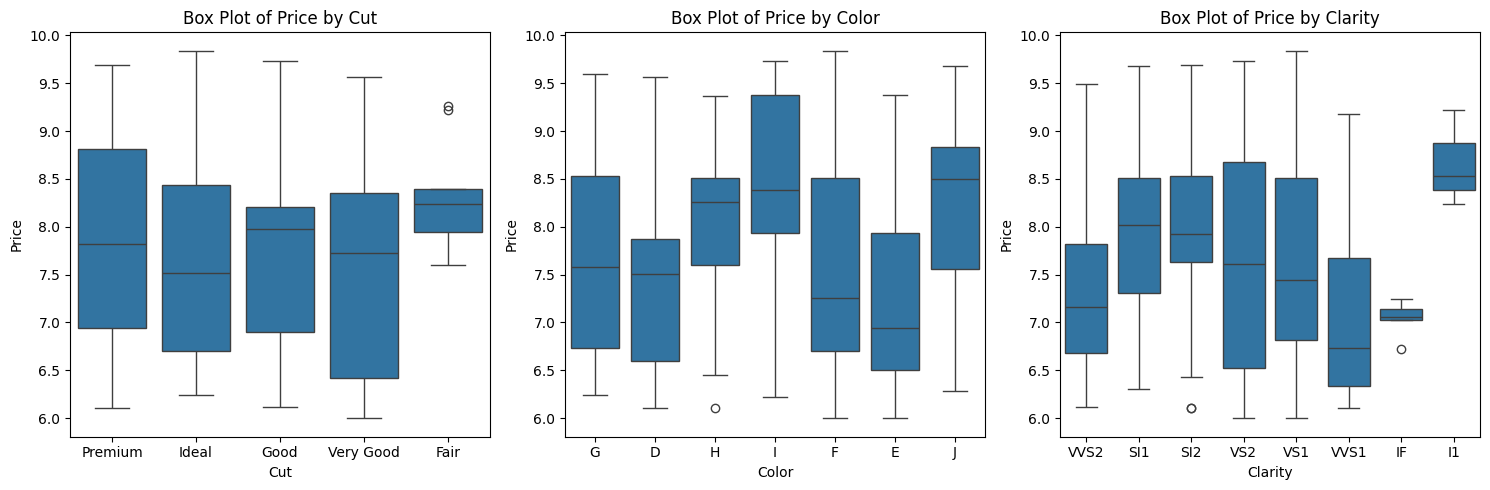

In [4]:
#uloha 1b)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 'cut'
sns.boxplot(ax=axes[0], x='cut', y='price', data=log_data)
axes[0].set_title('Box Plot of Price by Cut')
axes[0].set_xlabel('Cut')
axes[0].set_ylabel('Price')

# Plot for 'color'
sns.boxplot(ax=axes[1], x='color', y='price', data=log_data)
axes[1].set_title('Box Plot of Price by Color')
axes[1].set_xlabel('Color')
axes[1].set_ylabel('Price')

# Plot for 'clarity'
sns.boxplot(ax=axes[2], x='clarity', y='price', data=log_data)
axes[2].set_title('Box Plot of Price by Clarity')
axes[2].set_xlabel('Clarity')
axes[2].set_ylabel('Price')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

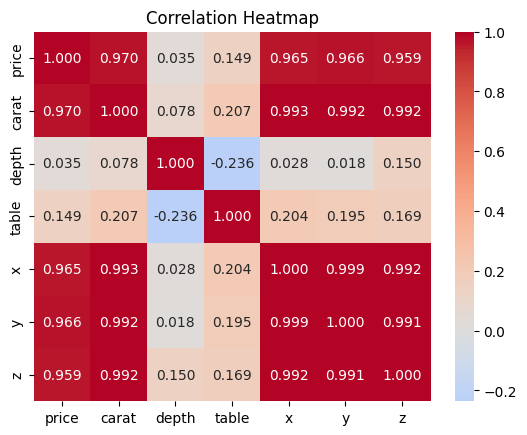

Proměnná 1| Proměnná 2| Korelace| p-hodnota| Interpretace
price| carat|  0.9700|  0.0000|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
price| depth|  0.0351|  0.6219|  Nezamítáme nulovou hypotézu, korelace je nulová.
price| table|  0.1492|  0.0350|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
price| x|  0.9649|  0.0000|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
price| y|  0.9664|  0.0000|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
price| z|  0.9588|  0.0000|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
carat| depth|  0.0783|  0.2702|  Nezamítáme nulovou hypotézu, korelace je nulová.
carat| table|  0.2074|  0.0032|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
carat| x|  0.9930|  0.0000|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
carat| y|  0.9923|  0.0000|  Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými.
carat| z|  0.9917|  0.0000|  Zamítáme 

In [5]:
# korelacni analyza
# uloha 2a)

pearson_corr = log_data[continuous_vars].corr(method='pearson') 

def plot_heatmap(corr_matrix, title, cmap='coolwarm'):
    sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap=cmap, center=0)
    plt.title(title)
    plt.show()

plot_heatmap(pearson_corr, "Correlation Heatmap")

def test_correlation_hypothesis(data, variables):
    results = []
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            var1, var2 = variables[i], variables[j]
            
            pearson_corr, pearson_pval = pearsonr(data[var1], data[var2])
            pearson_interpretation = "Zamítáme nulovou hypotézu, existuje korelace mezi proměnnými." if pearson_pval <= 0.05 else "Nezamítáme nulovou hypotézu, korelace je nulová."
            results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Correlation': pearson_corr,
                'p-value': pearson_pval,
                'Interpretation': pearson_interpretation,
            })

    for result in results:
        output = f"{result['Variable 1']}| {result['Variable 2']}|  {result['Correlation']:.4f}|  {result['p-value']:.4f}|  {result['Interpretation']}  "
        wrapped_output = textwrap.fill(output, width=125)
        print(wrapped_output)

    return results

print("Proměnná 1| Proměnná 2| Korelace| p-hodnota| Interpretace")
correlation_results = test_correlation_hypothesis(log_data[continuous_vars], continuous_vars)

In [6]:
# uloha 2b)
def compute_partial_correlation_multiple(df, vars_relationship, vars_control, significance_level=0.05):
    
    results = []
    N = len(df)  # Sample size
    k = len(vars_control)  # Number of covariates
    
    for i, var1 in enumerate(vars_relationship):
        for var2 in vars_relationship[i + 1:]:
            # Compute partial correlation between var1 and var2, controlling for vars_control
            result = pg.partial_corr(data=df, x=var1, y=var2, covar=vars_control, method='pearson')

            # Extract values
            partial_corr_coeff = result['r'].values[0]
            p_value = result['p-val'].values[0]
            
            # Manually compute degrees of freedom
            dof = N - k - 2
            
            # Compute the test statistic
            t_statistic = partial_corr_coeff * np.sqrt(dof / (1 - partial_corr_coeff**2))
            
            # Hypothesis test interpretation
            is_significant = p_value < significance_level
            if is_significant:
                interpretation = f"Zamítnutí nulové hypotézy: Parciální korelační koeficient je nenulový."
            else:
                interpretation = f"Nepodařilo se zamítnout nulovou hypotézu: Parciální korelační koeficient je nulový."
            
            # Append results
            results.append({
                "Parciální korelace": vars_relationship, 
                "Dané":  vars_control,
                "Koeficient parciální korelace": partial_corr_coeff,
                "t-statistika": t_statistic,
                "p-hodnota": p_value,
                "Interpretace": interpretation
            })
    
    return results

vars_r = ['price', 'table']
vars_c = ['carat', 'depth']
results = compute_partial_correlation_multiple(log_data, vars_r, vars_c)

# print("Partial Correlation Analysis Results:")
print(f"Parciální korelační koeficient price a table při daném carat a depth: {results[0]['Koeficient parciální korelace']:.4f}")
print(f"t-statistika: {results[0]['t-statistika']:.4f}")
print(f"p-hodnota: {results[0]['p-hodnota']:.4f}")
print(f"Interpretace: {results[0]['Interpretace']}")


Parciální korelační koeficient price a table při daném carat a depth: -0.2757
t-statistika: -4.0153
p-hodnota: 0.0001
Interpretace: Zamítnutí nulové hypotézy: Parciální korelační koeficient je nenulový.


In [7]:
# regression analysis forwards selection 
# 3a)
log_data_encoded = pd.get_dummies(log_data, columns=['cut', 'color', 'clarity'], drop_first=True)
log_data_encoded = log_data_encoded.astype(float)

def forward_selection(X, y, significance_level=0.05):
    # Initialize variables
    included = []  # List of included predictors
    remaining = list(X.columns)  # Variables not yet selected
    selected_model = None  # Final selected model
    print(remaining)

    while remaining:
        # Test each remaining variable by adding it to the current model
        results = []
        for var in remaining:
            current_vars = included + [var]
            model = sm.OLS(y, sm.add_constant(X[current_vars])).fit()
            p_value = model.pvalues[var]
            results.append((p_value, var, model))

        # Select the variable with the lowest p-value
        results.sort(key=lambda x: x[0])
        best_p_value, best_var, best_model = results[0]

        # Stop if no variable meets the significance level
        if best_p_value < significance_level:
            included.append(best_var)
            remaining.remove(best_var)
            selected_model = best_model
            r2 = best_model.rsquared
            adj_r2 = best_model.rsquared_adj
            print(f"Added {best_var}, R^2: {r2:.4f}, Adjusted R^2: {adj_r2:.4f}")
        else:
            break

    return included


y=log_data_encoded['price']
X=log_data_encoded.drop(columns=['price'])
included = forward_selection(X, y)
 



['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
Added carat, R^2: 0.9409, Adjusted R^2: 0.9406
Added clarity_SI2, R^2: 0.9483, Adjusted R^2: 0.9478
Added clarity_SI1, R^2: 0.9524, Adjusted R^2: 0.9517
Added color_I, R^2: 0.9548, Adjusted R^2: 0.9538
Added color_J, R^2: 0.9576, Adjusted R^2: 0.9565
Added color_H, R^2: 0.9594, Adjusted R^2: 0.9581
Added cut_Ideal, R^2: 0.9611, Adjusted R^2: 0.9597
Added depth, R^2: 0.9630, Adjusted R^2: 0.9614
Added clarity_VVS1, R^2: 0.9646, Adjusted R^2: 0.9630
Added clarity_VVS2, R^2: 0.9668, Adjusted R^2: 0.9650
Added clarity_IF, R^2: 0.9685, Adjusted R^2: 0.9666
Added color_G, R^2: 0.9702, Adjusted R^2: 0.9682
Added clarity_VS1, R^2: 0.9716, Adjusted R^2: 0.9696
Added clarity_VS2, R^2: 0.9857, Adjusted R^2: 0.9846
Added x, R^2: 0

In [8]:
# 3b)
modelll = sm.OLS(y, X[included]).fit()

# Display the model properly
print(modelll.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.070e+04
Date:                Tue, 04 Mar 2025   Prob (F-statistic):                   2.22e-317
Time:                        23:05:22   Log-Likelihood:                          129.90
No. Observations:                 200   AIC:                                     -225.8
Df Residuals:                     183   BIC:                                     -169.7
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [9]:
# 3c)
def estimate_variance_submodel(model):
    rss = sum(model.resid**2)
    df = model.df_resid
    variance = rss / df
    return variance

variance_estimate = estimate_variance_submodel(modelll)
print(f"Unbiased Estimate of Variance: {variance_estimate:.10f}")

Unbiased Estimate of Variance: 0.0174556173


In [10]:
#  3d)
def test_pairs_for_null_hypothesis(model,variables, alpha=0.05):
    results = []
    
    for i, var1 in enumerate(variables):
        for var2 in variables[i + 1:]:
            hypothesis = f"{var1} = {var2}"
            wald_test = model.wald_test(hypothesis, scalar=True)
            stat = wald_test.statistic
            p_value = wald_test.pvalue
            conclusion = ("Odmítám. H0: Úrovně mají různé efekty." 
                          if p_value < alpha 
                          else "Neodmítám H0: Úrovně mají stejný efekt.")
            results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Test Statistic': stat,
                'p-value': p_value,
                'Conclusion': conclusion
            })
            
            print(f"{var1} {var2}| Waldova statistika: {stat:.4f}| p-hodnota: {p_value:.4f}| {conclusion}")
    
    return results

def filter_and_split_categories(selected_vars, continuous_vars):
    filtered_vars = [var for var in selected_vars if var not in continuous_vars]
    categories = {}
    for var in filtered_vars:
        if "_" in var:  # Identify categorical variables by the naming convention
            category, discrete_value = var.split("_", 1)
            if category not in categories:
                categories[category] = []
            categories[category].append(var)
    
    return categories

categories = filter_and_split_categories(included, continuous_vars)

for _, variables in categories.items():
    test_pairs_for_null_hypothesis(modelll, variables)

 

clarity_SI2 clarity_SI1| Waldova statistika: 29.6074| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI2 clarity_VVS1| Waldova statistika: 133.9523| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI2 clarity_VVS2| Waldova statistika: 148.3252| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI2 clarity_IF| Waldova statistika: 79.1315| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI2 clarity_VS1| Waldova statistika: 126.6649| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI2 clarity_VS2| Waldova statistika: 88.2323| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI1 clarity_VVS1| Waldova statistika: 71.0077| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI1 clarity_VVS2| Waldova statistika: 69.1289| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají různé efekty.
clarity_SI1 clarity_IF| Waldova statistika: 42.7045| p-hodnota: 0.0000| Odmítám. H0: Úrovně mají r

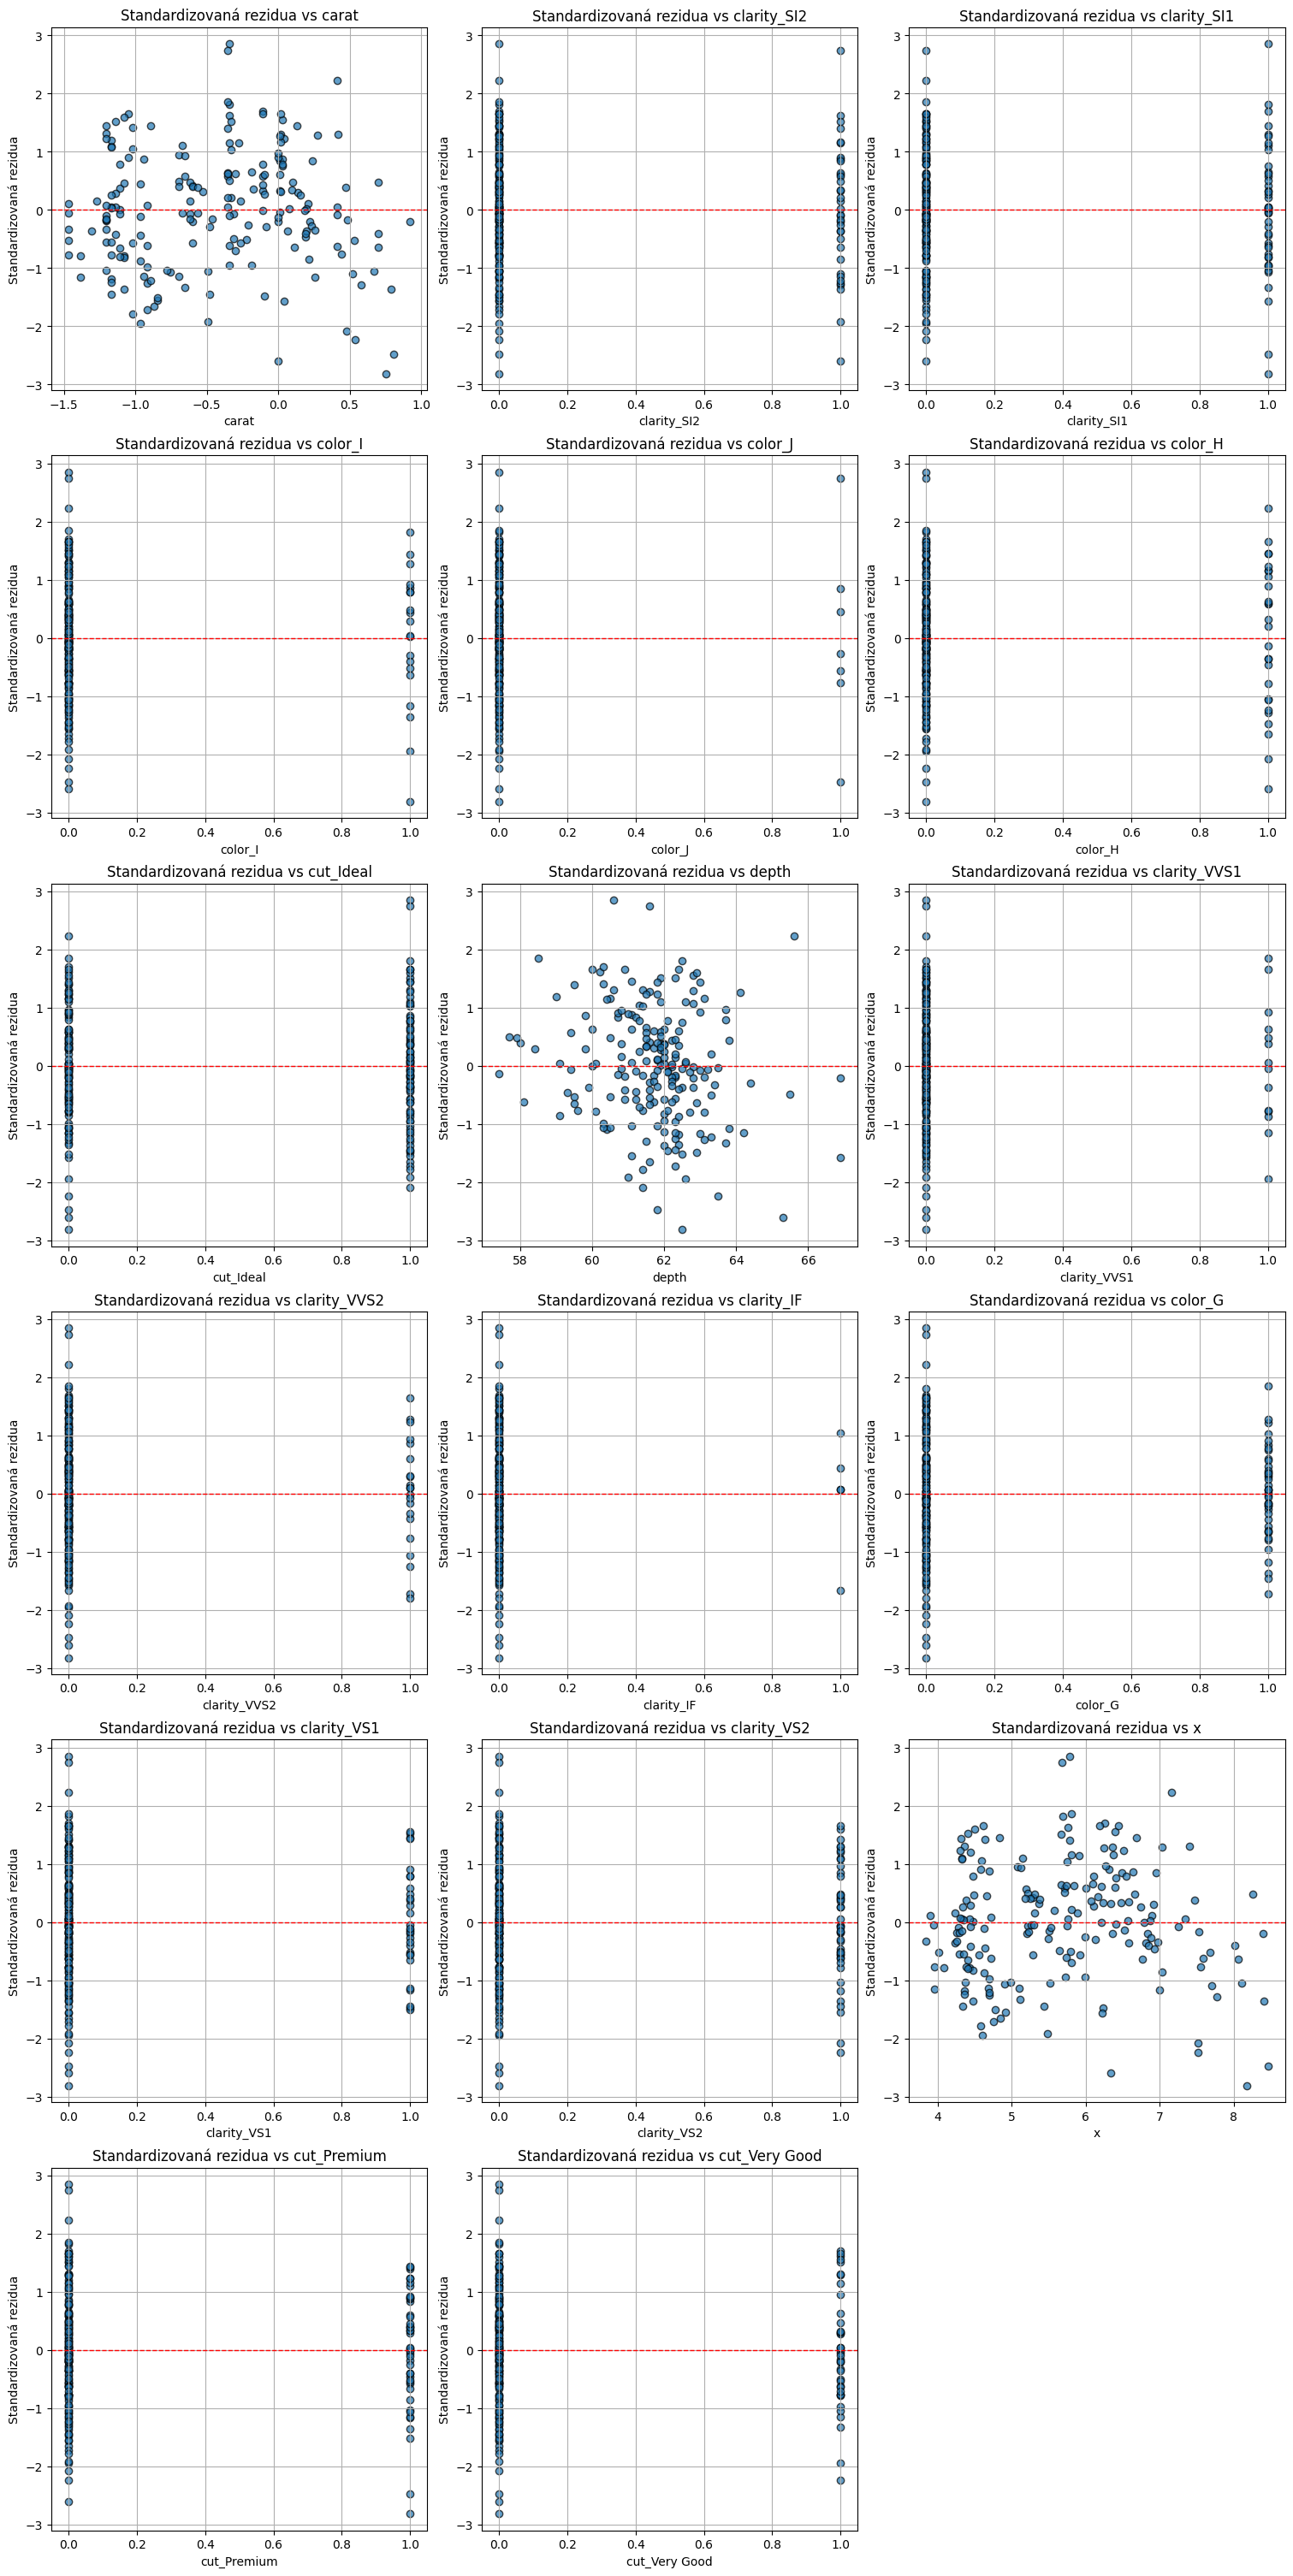

Breusch-Pagan statistika: 19.1152, p-hodnota: 0.3220, Rezidua jsou homoskedastická.


In [11]:
# 4a)
def plot_residuals_vs_explanatory_combined(model, X):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import statsmodels.stats.api as sms

    # Add a constant to X if it's not already present
    X_with_constant = sm.add_constant(X, has_constant='add')

    # Calculate standardized residuals
    standardized_residuals = model.get_influence().resid_studentized_internal

    # Number of variables to plot
    n_vars = len(X.columns)
    n_cols = 3  # Number of columns in the grid
    n_rows = (n_vars + n_cols - 1) // n_cols  # Calculate rows needed

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5* n_rows), constrained_layout=True)

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Plot each explanatory variable
    for i, column in enumerate(X.columns):
        axes[i].scatter(X[column], standardized_residuals, alpha=0.7, edgecolor='k')
        axes[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
        axes[i].set_title(f'Standardizovaná rezidua vs {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Standardizovaná rezidua')
        axes[i].grid()

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

    # Test for homoscedasticity using Breusch-Pagan test
    test_result = sms.het_breuschpagan(model.resid, X_with_constant)
    bp_stat, bp_pvalue = test_result[0], test_result[1]

    if bp_pvalue < 0.05:
        comment = "Rezidua jsou heteroskedastická."
        print(f"Breusch-Pagan statistika: {bp_stat:.4f}, p-hodnota: {bp_pvalue:.4f}, {comment}")
    else:
        comment = "Rezidua jsou homoskedastická."
        print(f"Breusch-Pagan statistika: {bp_stat:.4f}, p-hodnota: {bp_pvalue:.4f}, {comment}")

plot_residuals_vs_explanatory_combined(modelll, X[included])


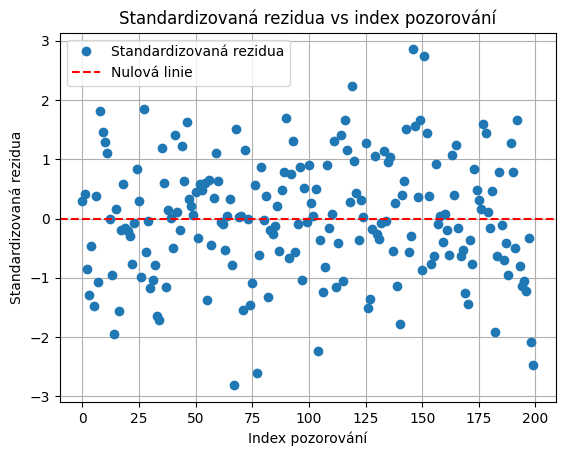

Durbin-Watson statistika: 1.7363, Rezidua jsou nezávislá.


In [12]:
# 4b)
def plot_standardized_residuals_and_durbin_watson_test(model):
    standardized_residuals = model.get_influence().resid_studentized_internal
    
    plt.plot(standardized_residuals, marker='o', linestyle='', label='Standardizovaná rezidua')
    plt.axhline(y=0, color='red', linestyle='--', label='Nulová linie')
    plt.title('Standardizovaná rezidua vs index pozorování')
    plt.xlabel('Index pozorování')
    plt.ylabel('Standardizovaná rezidua')
    plt.legend()
    plt.grid()
    plt.show()
    
    dw_stat = sm.stats.durbin_watson(model.resid)

    if dw_stat < 1.5:
        comment = "Rezidua vykazují pozitivní autokorelaci."
        print(f"Durbin-Watson statistika: {dw_stat:.4f}, {comment}")
    elif 1.5 <= dw_stat <= 2.5:
        comment = "Rezidua jsou nezávislá."
        print(f"Durbin-Watson statistika: {dw_stat:.4f}, {comment}")
    else:
        comment = "Rezidua vykazují negativní autokorelaci."
        print(f"Durbin-Watson statistika: {dw_stat:.4f}, {comment}")
    

plot_standardized_residuals_and_durbin_watson_test(modelll)

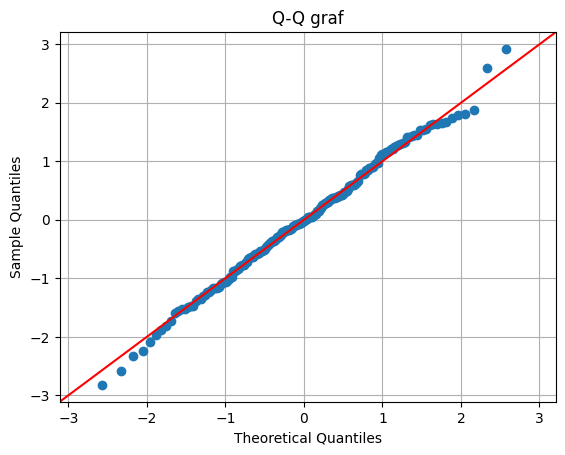

Shapiro-Wilk statistika: 0.9963, p-hodnota: 0.9107, Rezidua sledují normální rozdělení.


In [13]:
# 4c)
def verify_normality_of_residuals(model):
    # Extract residuals
    residuals = model.resid

    # Plot Q-Q plot
    sm.qqplot(residuals, line='45', fit=True)
    plt.title('Q-Q graf')
    plt.grid()
    plt.show()

    # Perform Shapiro-Wilk test for normality
    stat, p_value = shapiro(residuals)

    # Comment on normality
    if p_value < 0.05:
        comment = "Rezidua nesledují normální rozdělení."
        print(f"Shapiro-Wilk statistika: {stat:.4f}, p-hodnota: {p_value:.4f}, {comment}")
    else:
        comment = "Rezidua sledují normální rozdělení."
        print(f"Shapiro-Wilk statistika: {stat:.4f}, p-hodnota: {p_value:.4f}, {comment}")

verify_normality_of_residuals(modelll)

In [14]:
# 4d)
def predict_with_interval(model, X, y, alpha=0.05):
    # Get the first observation
    first_observation = X.iloc[0:1]

    # Make prediction and calculate prediction interval
    prediction = model.get_prediction(first_observation)
    prediction_summary = prediction.summary_frame(alpha=alpha)

    # Extract values
    predicted_value = prediction_summary['mean'].iloc[0]
    lower_bound = prediction_summary['obs_ci_lower'].iloc[0]
    upper_bound = prediction_summary['obs_ci_upper'].iloc[0]

    # Get the real value for the first observation
    real_value = y.iloc[0]

    return predicted_value, lower_bound, upper_bound, real_value

# Example usage
predicted_value, lower_bound, upper_bound, real_value = predict_with_interval(modelll, X[included], y)
print(f"Skutečná hodnota: {real_value:.4f}")
print(f"Predikovaná hodnota: {predicted_value:.4f}")
print(f"Interval predikce: [{lower_bound:.4f}, {upper_bound:.4f}]")



Skutečná hodnota: 9.0479
Predikovaná hodnota: 9.0107
Interval predikce: [8.7361, 9.2853]


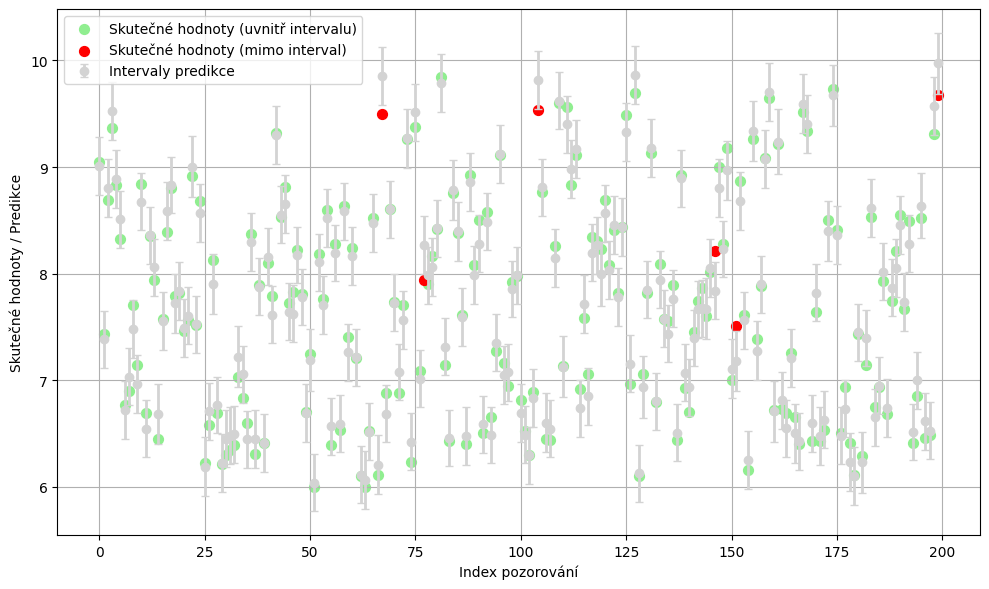

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Real Values,Observation Index
0,9.010721,0.043787,8.924329,9.097112,8.736104,9.285337,9.047939,0
1,7.383792,0.028834,7.326901,7.440683,7.116983,7.650602,7.437206,1
2,8.803010,0.034808,8.734333,8.871687,8.533441,9.072579,8.694335,2
3,9.525931,0.037274,9.452388,9.599474,9.255082,9.796780,9.362460,3
4,8.889789,0.040641,8.809604,8.969973,8.617061,9.162516,8.831858,4
...,...,...,...,...,...,...,...,...
195,8.635807,0.081661,8.474690,8.796924,8.329360,8.942254,8.526153,195
196,6.613493,0.035064,6.544312,6.682674,6.343796,6.883191,6.458338,196
197,6.526810,0.035779,6.456218,6.597402,6.256747,6.796873,6.484635,197
198,9.573109,0.038085,9.497966,9.648251,9.301821,9.844397,9.309733,198


In [15]:
def plot_predictions_with_intervals(model, X, y, alpha=0.05):

    # Make predictions and calculate prediction intervals
    prediction = model.get_prediction(X)
    prediction_summary = prediction.summary_frame(alpha=alpha)

    # Add observed data for comparison
    prediction_summary['Real Values'] = y
    prediction_summary['Observation Index'] = range(len(X))
    prediction_summary = prediction_summary.reset_index(drop=True)

    # Determine if real value is inside the prediction interval
    inside_interval = (prediction_summary['Real Values'] >= prediction_summary['obs_ci_lower']) & \
                      (prediction_summary['Real Values'] <= prediction_summary['obs_ci_upper'])

    # Plot prediction intervals and real values
    plt.figure(figsize=(10, 6))

    # Plot real values inside prediction interval (blue)
    plt.scatter(
        prediction_summary['Observation Index'][inside_interval],
        prediction_summary['Real Values'][inside_interval],
        color='lightgreen',  # Real values inside the interval
        s=50,          # Size of points
        label='Skutečné hodnoty (uvnitř intervalu)'
    )

    # Plot real values outside prediction interval (red)
    plt.scatter(
        prediction_summary['Observation Index'][~inside_interval],
        prediction_summary['Real Values'][~inside_interval],
        color='red',   # Real values outside the interval
        s=50,          # Size of points
        label='Skutečné hodnoty (mimo interval)'
    )

    # Plot prediction intervals (as error bars)
    plt.errorbar(
        prediction_summary['Observation Index'],
        prediction_summary['mean'],
        yerr=[
            prediction_summary['mean'] - prediction_summary['obs_ci_lower'],
            prediction_summary['obs_ci_upper'] - prediction_summary['mean']
        ],
        fmt='o',         # Format as circle
        color='lightgray',   # Error bar color
        ecolor='lightgray',  # Color of the error bars
        elinewidth=2,    # Error bar line thickness
        capsize=3,       # Error bar cap size
        label='Intervaly predikce'
    )

    # Title and labels
    plt.xlabel('Index pozorování')
    plt.ylabel('Skutečné hodnoty / Predikce')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return prediction_summary

predictions = plot_predictions_with_intervals(modelll, X[included], y)
predictions.head(200)

